In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
path = '/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar'
sys.path.append(path)
import netflix_functions as nf

In [2]:
df = pd.read_excel(path+'/dataset_netflix.xlsx',engine='openpyxl')

## Tratamento de dados (Pre-processing)

### Remoção de dados

Os filmes sem avaliação ou sem data de adição no catálogo(12), com avaliação igual a zero (330) e com data de adição no catálogo anterior a data do lançamento (8) foram removidos. Esses dados foram removidos pela não usabilidade nas etapas de treino e teste (filmes sem avaliação) ou por apresentar dados inconsistentes.

In [3]:
df = df[(df['rating']!=0) & (df['rating'].isnull() == False)] 
df.dropna(inplace=True,subset=['date_added'])

In [4]:
df['year'] = df['date_added'].dt.year
df['years_since_release'] = df['year']-df['release_year']
df = df[df['years_since_release']>=0]

### Encoding

Filmes foram transformados em 1 e séries em 0.

Duration foi transformado em int, e as linhas que possuiam season transformadas em np.nan.

Mantive linhas sem informações de cast como 'bam' e sem informação de country como 'None', para diretores transformei os que estavam faltando dados para 'no director'.

In [5]:
df['type'] = df['type'].apply(nf.movie_tv)
df['type'].head()

0    1
1    1
2    0
3    0
4    1
Name: type, dtype: int64

In [6]:
df['duration'] = df['duration'].apply(nf.time)
df['duration'].head()

0    90.0
1    94.0
2     NaN
3     NaN
4    99.0
Name: duration, dtype: float64

In [7]:
df['director'] = df.director.fillna('no director')
df['director'].head()

0    Richard Finn, Tim Maltby
1                 no director
2                 no director
3                 no director
4            Fernando Lebrija
Name: director, dtype: object

## Feature Engeneering

### Pré divisão em treino e teste

Adição do ano de lançamento na plataforma 'year' e quantos anos demorou para ser lançado na plataforma desde o lançamento do filme 'years_since_release'.

In [8]:
df['year'] = df['date_added'].dt.year
df['years_since_release'] = df['year']-df['release_year']

### Durante treino e test

In [9]:
df = pd.read_excel(path+'/dataset_netflix.xlsx',engine='openpyxl')
df = nf.preprocessing(df,enrich=False)

variables = ['power listed_in','power director', 'power cast', 'power country','size cast',
             'size listed_in','size director','type','release_year','duration','years_since_release','year']

tcv = TimeSeriesSplit(n_splits=4)

X, y = df, df['rating']

for train_index, test_index in tcv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train,y_train,X_test,y_test = nf.feature_eng_enc(X_train,y_train,X_test,y_test,3,percentile=25)    
    X_train = X_train[variables]
    X_test = X_test[variables]

/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['director'] = df.director.fillna('no director')
/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True,subset=['date_added'])
/home/jubi/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

TRAIN: [   0    1    2 ... 1177 1178 1179] TEST: [1180 1181 1182 ... 2353 2354 2355]


/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['power '+i] = X_train['single '+i].apply(power, args=(X_train_g,freq))
/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['power '+i] = X_test['single '+i].apply(power, args=(X_train_g,freq))
/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow e

TRAIN: [   0    1    2 ... 2353 2354 2355] TEST: [2356 2357 2358 ... 3529 3530 3531]
TRAIN: [   0    1    2 ... 3529 3530 3531] TEST: [3532 3533 3534 ... 4705 4706 4707]
TRAIN: [   0    1    2 ... 4705 4706 4707] TEST: [4708 4709 4710 ... 5881 5882 5883]


Variáveis com size é o número de atóres, diretores e países de cada linha.

Variáveis com power são obtidas a partir da média do desempenho e cada um dos atóres/diretores/países, é colocado uma limitação dada por uma variável freq, no número mínimo de aparições de um ator por exemplo para ele possuir um valor na power.

Rating é substituido por 0 ou 1 dependendo do segundo quartil (percentil 50) dos dados de treino.
A escolha do quartil depende fortemente da estratégia de negócios da empresa.

In [10]:
variables = ['power listed_in','power director', 'power cast', 'power country','size cast',
             'size listed_in','size director','type','release_year','duration','years_since_release','year']

display(X_train[variables].head())
display(y_train.head())

,power listed_in,power director,power cast,power country,size cast,size listed_in,size director,type,release_year,duration,years_since_release,year
0,64.355051,NaN,NaN,67.138056,6,3,1,1,2006.0,81.0,2.0,2008
1,70.566667,72.545712,69.295302,67.138056,0,1,0,0,2007.0,NaN,1.0,2008
2,66.248079,NaN,NaN,70.352941,12,2,1,1,2007.0,104.0,2.0,2009
3,57.288660,NaN,53.500000,67.138056,6,1,1,1,2009.0,29.0,0.0,2009
4,63.427663,NaN,NaN,67.138056,10,2,1,1,1987.0,84.0,23.0,2010


0    0
1    0
2    0
3    1
4    0
Name: rating, dtype: int64

## Divisão de treino e teste

Para a divisão do dataset primeiro assumi que os dados utilizando para o treino precisam ser anteriores aos dados de teste, logo date_added no dataset de treino < date_added no dataset de teste, sendo assim utilizei o TimeSeriesSplit para dividir os dados corretamente.

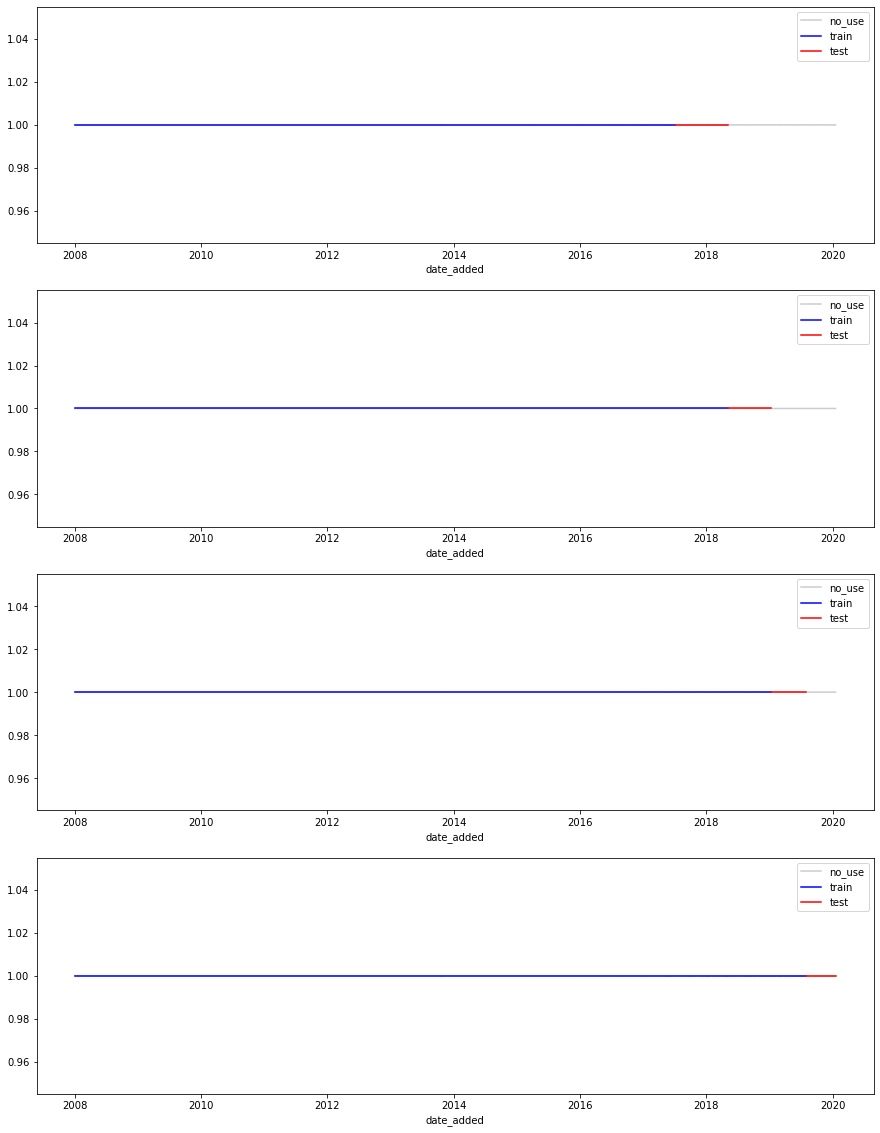

In [11]:
fig, axes = plt.subplots(4, 1, figsize=(15, 20))  
for i, (train_index, test_index) in enumerate(tcv.split(df)):  
    sns.lineplot(data=df, x='date_added', y=[1]*len(df), ax=axes[i], label='no_use',color="0.8")  
    sns.lineplot(data=df.iloc[train_index], x='date_added', y=[1]*len(df.iloc[train_index]), ax=axes[i], label='train',color="b")  
    sns.lineplot(data=df.iloc[test_index], x='date_added', y=[1]*len(df.iloc[test_index]), ax=axes[i], label='test',color="r")  

plt.legend()  
plt.show() 

## Resultado do modelo

In [12]:
import netflix_model as nm
f1_test, f1_train, precision_test, precision_train, recall_test, recall_train, last_conf = nm.model_results()

/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['director'] = df.director.fillna('no director')
/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True,subset=['date_added'])
/home/jubi/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

TRAIN: [   0    1    2 ... 1177 1178 1179] TEST: [1180 1181 1182 ... 2353 2354 2355]


/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['power '+i] = X_train['single '+i].apply(power, args=(X_train_g,freq))
/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['power '+i] = X_test['single '+i].apply(power, args=(X_train_g,freq))
/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow e

[12:20:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['duration'] = X_train['duration'].apply(time)
/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['duration'] = X_test['duration'].apply(time)
/home/jubi/Documents/Pesquisa/Processo seletivo /Eleflow/Eleflow entregar/netflix_functions.py:91: SettingWithCopyWa

[12:20:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[12:21:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

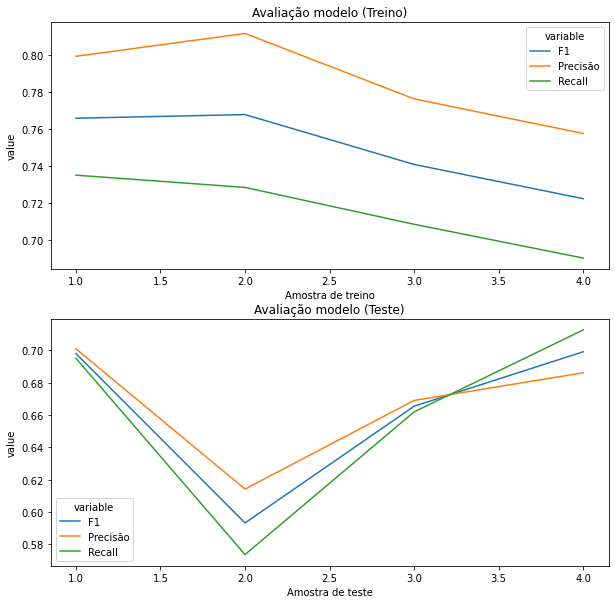

In [13]:
test_order = [1,2,3,4]
test_data = pd.DataFrame({
    'Amostra de teste': test_order, 
    'F1': f1_test,
    'Precisão': precision_test,
    'Recall': recall_test})


train_data = pd.DataFrame({
    'Amostra de treino': test_order, 
    'F1': f1_train,
    'Precisão': precision_train,
    'Recall': recall_train})
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 10))  

sns.lineplot(x='Amostra de treino', y='value', ax=axes[0], hue='variable', 
             data=pd.melt(train_data, ['Amostra de treino'])).set_title('Avaliação modelo (Treino)')

sns.lineplot(x='Amostra de teste', y='value',ax=axes[1], hue='variable', 
             data=pd.melt(test_data, ['Amostra de teste'])).set_title('Avaliação modelo (Teste)')


plt.show()

### Confusion Matrix da última amostra de teste

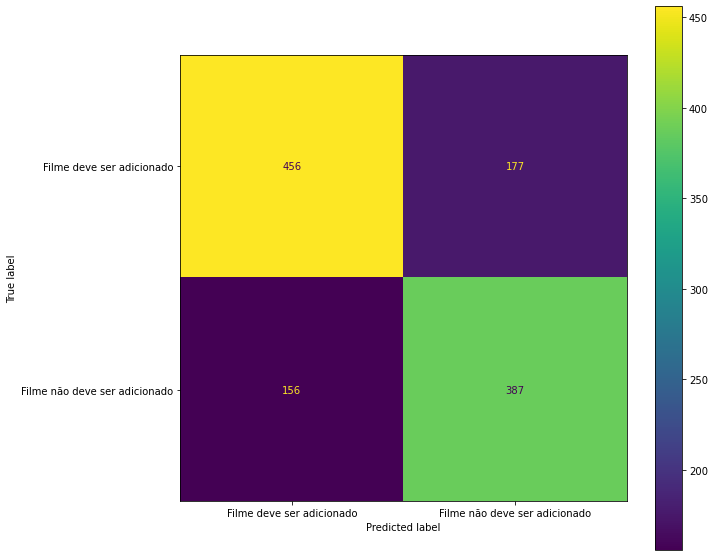

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(1, 1, figsize=(10, 10))  
ConfusionMatrixDisplay(last_conf,display_labels=['Filme deve ser adicionado',
                                                'Filme não deve ser adicionado']).plot(ax = axes)
plt.show()

## O que fazer para melhorar o modelo

### Melhorias internas:

1- Identificação do país de quem está avaliando o filme. 

2- Número de pessoas que avaliaram o filme.

3- Probabilidade desse filme ser indicado para alguém.

4- Número de pessoas que assistiram.

5- Objetivo de negócios. Ex: Se é desejado fazer um aumento, redução ou manutenção do catálogo.

6- Uso de graphos para relações entre atores/diretores que trabalharam juntos.

7- Avaliação individual de cada usuário, com informações do usuário.

### Melhorias por enriquecimento

1- Quantidade faturada pelo filme.

2- Custos com divulgação.

3- Produtora do filme. 

4- Tempo de produção do filme.

5- Data do lançamento

6- Avaliação em sites como rotten tomatoes ou IMDB.

7- Geração de novas variáveis "power" utilizando os ratings do IMDB/Rotten Tomatoes

8- Filme direto para home video ou não?